# LSI31003 Machine Learning in Molecular Biology
## Peptide classification group project

### Introduction:
In Assignment 3, you learned how pretrained transformer models could be used to learn embeddings for short peptide sequences, and how those embeddings could then be further used in downstream machine learning tasks. In assignment 3 we built a classifier to predict whether a given short peptide was of antimicrobial origin (AMP) vs non-Antimicrobial (nonAMP), based on the information contained within its sequence alone.

However, short peptide sequences have also other important functionality in living organisms than just Antimicrobial effects. In this group assignment, you will investigate peptides with multiple biological functionalities. 

Dataset comes from a curated short peptide collection described in (Xiao, B. *et al.*): **A comprehensive dataset of therapeutic peptides on multi-function property and structure information** (https://doi.org/10.1038/s41597-025-05528-1). Read the paper to find further details on how the peptides are classified (main and subcategories), as well as descriptions for the peptide metadata table.

For this task, we have calculated the ESM-2 embeddings for you in advance. All performed preprocessing steps are described in Peptide_project_preprocessing.ipynb. Furthermore, there is a second set of embeddings that is further derived from ESM-2 embeddings using supervised learning methods (known labels) with a deep learning framework (with combination of autoencoder-like reproducibility loss and prediction accuracy for the target label vector). You can use this set of embeddings as well, but if you are familiar with deep learning libraries such as pytorch and tensorflow, it's higly recommended that you try to learn suitable optimized embeddings yourself (but this is not a necessity)! The raw ESM-2 embeddings might also work on their own, but it's up to you to decide/ try out.

### Your task:
Your task is to built a classifier that predicts the peptide classes with as good accuracy as possible, mainly using the embedding representations as inputs (feel free to try other feature engineering methods as well if you like!). Apply dimensionsionality reduction methods if deemed appropriate. You should first make the classifier for the 15 main categories. After that, you can also try to predict the subcategories within each main peptide category. You should do model selection and show performance with confusion matrix visualizations and/or other general accuracy metrics.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# your library imports

In [28]:
# peptides with available metadata
meta = pd.read_csv("./data/Peptide_Metadata.csv", index_col = 0)
print(f"{meta.shape[0]} total peptides.")
meta.head(5)

17265 total peptides.


,Function,Label encoding,Sequence,Source,Is_natural_peptide,HELM notation,N-terminal modification,C-terminal modification,Post translation modifications,Reference
ID,,,,,,,,,,
100004,"Antimicrobial|Antibacterial|Anti-gram+,Antimic...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,Human,True,PEPTIDE1{[ac].A.A.A.A.A.A.A.A.A.A.G.I.G.K.F.L....,NaN,NaN,NaN,"Antimicrob Agents Chemother, 1992, 36, 313;PMI..."
100007,"Antimicrobial|Antibacterial|Anti-gram+,Antimic...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",AAAAAAAIKMLMDLVNERIMALNKKAKK,virus (Bovine papular stomatitis virus)|Bovine...,True,PEPTIDE1{[ac].A.A.A.A.A.A.A.I.K.M.L.M.D.L.V.N....,NaN,NaN,NaN,"PLoS One, 2012, 7, e45848;PMID: 23029273"
100013,"Antimicrobial|Antibacterial|Anti-gram+,Antimic...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",AAAAGSCVWGAVNYTSDCAAECKRRGYKGGHCGSFANVNCWCET,ND,True,PEPTIDE1{[ac].A.A.A.A.G.S.C.V.W.G.A.V.N.Y.T.S....,NaN,NaN,NaN,"Biochemistry, 2001, 40, 11995;PMID: 11580275"
100014,"Antimicrobial|Antibacterial|Anti-gram+,Antimic...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",AAAAGSCVWGAVNYTSDCAAECKRRGYKGGHCGSFANVNCWCRT,ND,True,PEPTIDE1{[ac].A.A.A.A.G.S.C.V.W.G.A.V.N.Y.T.S....,NaN,NaN,NaN,"Biochemistry, 2001, 40, 11995;PMID: 11580275"
100015,"Antimicrobial|Antibacterial|Anti-gram+,Antimic...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",AAAAGSCVWGAVNYTSDCAAECLLRGYKGGHCGSFANVNCWCET,ND,True,PEPTIDE1{[ac].A.A.A.A.G.S.C.V.W.G.A.V.N.Y.T.S....,NaN,NaN,NaN,"Biochemistry, 2001, 40, 11995;PMID: 11580275"


In [29]:
# Embeddings from ESM2-model (same pipeline as in Assignment 3)
embeddings_esm = pd.read_csv("./data/Embeddings_Esm2.csv", index_col = 0)
print(f"{embeddings_esm.shape[1]} dimensional peptide embeddings from ESM-2 model")
embeddings_esm.head()

1280 dimensional peptide embeddings from ESM-2 model


,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
ID,,,,,,,,,,,,,,,,,,,,,
100004,-0.002897,0.032261,-0.061632,-0.012294,0.083954,-0.027361,-0.064955,0.041762,-0.006667,-0.117269,...,0.030947,-0.058636,-0.084253,0.144039,0.056908,0.058979,0.020752,0.068330,-0.123524,0.092439
100007,-0.021438,-0.036954,-0.018984,-0.015381,0.001480,-0.057479,-0.045701,0.061801,0.001520,-0.123927,...,0.036371,-0.038882,-0.012545,0.093841,0.050679,0.047878,0.106075,-0.061094,-0.028786,0.008304
100013,-0.010459,-0.011805,0.022508,0.043741,0.000519,0.033871,0.051326,-0.015819,0.054000,0.081105,...,0.080855,0.000629,0.045531,-0.001710,-0.054935,-0.035005,0.033414,-0.098053,-0.008366,0.099628
100014,-0.029972,-0.022473,0.018484,0.042649,-0.010375,0.047744,0.059621,-0.011444,0.034726,0.089829,...,0.074273,-0.021156,0.043835,0.022560,-0.047037,-0.015590,0.029909,-0.103113,0.008463,0.077277
100015,-0.011639,-0.005451,0.037088,0.048091,0.013870,0.033050,0.023372,0.010481,0.066343,0.064727,...,0.087427,0.014022,0.045259,-0.006255,-0.051198,-0.025632,0.039032,-0.091726,-0.007044,0.110314


In [30]:
# Mystery embeddings: derivation from ESM-embeddings optimized with deeplearning methods and known labels.
embeddings_finetuned = pd.read_csv("./data/Embeddings_Mysteryengineered.csv", index_col = 0)
print(f"{embeddings_finetuned.shape[1]} dimensional peptide embeddings downstream engineered from ESM-2 model")
embeddings_finetuned.head()

200 dimensional peptide embeddings downstream engineered from ESM-2 model


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
ID,,,,,,,,,,,,,,,,,,,,,
100004,-0.483709,-0.557164,-0.420388,-0.175160,0.793239,0.120372,-0.146778,0.119034,0.344554,0.565946,...,0.154780,-0.338444,-0.211424,0.650465,0.168623,0.403776,0.295616,-0.637571,-0.235686,-0.062087
100007,-0.384557,-0.158466,-0.540723,-0.139707,0.417634,0.441971,-0.197034,0.160257,0.352310,0.503866,...,0.320291,-0.296480,-0.400126,0.744250,0.055119,0.386485,0.189654,-0.393325,-0.190110,-0.113808
100013,-0.444259,0.233969,-0.649846,-0.301525,0.378391,0.652291,0.120221,0.060428,0.113184,0.017043,...,0.378905,-0.317880,-0.147875,0.019434,0.200457,0.386632,0.220315,-0.026951,0.105835,-0.316225
100014,-0.447115,0.242742,-0.640375,-0.313176,0.381286,0.642577,0.129668,0.057654,0.108229,0.009943,...,0.386476,-0.319757,-0.132476,-0.004574,0.210770,0.409565,0.223644,-0.020175,0.093596,-0.305084
100015,-0.435927,0.249961,-0.656335,-0.319148,0.338178,0.657516,0.122982,0.063526,0.093505,0.011224,...,0.391172,-0.316295,-0.174601,0.020248,0.212861,0.350936,0.193509,-0.018062,0.098034,-0.329183


**Labels -table columns:**  
`MAIN_category` one of the main 15 categories defined in the table (or "Multipurpose" if peptide belongs to multiple categories).  
`isSinglepurpose`: True if only 1 main category, False if MAIN_Category = "Multipurpose"  
`other columns`: Other peptide subtypes from the paper, corresponding to `Label encoding` -column of the meta table.

In [31]:
labels = pd.read_csv("./data/Peptide_Targetlabels.csv", index_col = 0)
labels


,MAIN_Category,isSinglepurpose,Analgesic,Angiogenic,Anti-gram+,Anti-gram-,AntiAngiogenesis,AntiBreastcancer,AntiCervicalcancer,AntiColoncancer,...,Growth_regulatory,Immunoactive,Lipid_metabolism,Metabolic_regulatory,Neuropeptide,Opioid,Osteogenic,Quorum_sensing,Thrombolytic,Tumor_homing
ID,,,,,,,,,,,,,,,,,,,,,
100004,Antibacterial,True,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100007,Antibacterial,True,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100013,Multipurpose,False,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100014,Multipurpose,False,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100015,Multipurpose,False,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154636,Antibacterial,True,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154646,Neuropeptide,True,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
154648,Antimicrobial,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


MAIN_Category
Antimicrobial           4916
Multipurpose            4413
Antibacterial           3740
Antiviral               1460
Neuropeptide            1010
Antifungal               509
Metabolic_regulatory     406
Antiparasitic            230
Cell_Communication       226
Anticancer               100
Drug_delivery             73
Antihypertensive          73
Growth_regeneration       65
Immunoactive              27
Antioxidant               14
Thrombolytic               3
Name: count, dtype: int64


/tmp/ipykernel_156687/855664598.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')


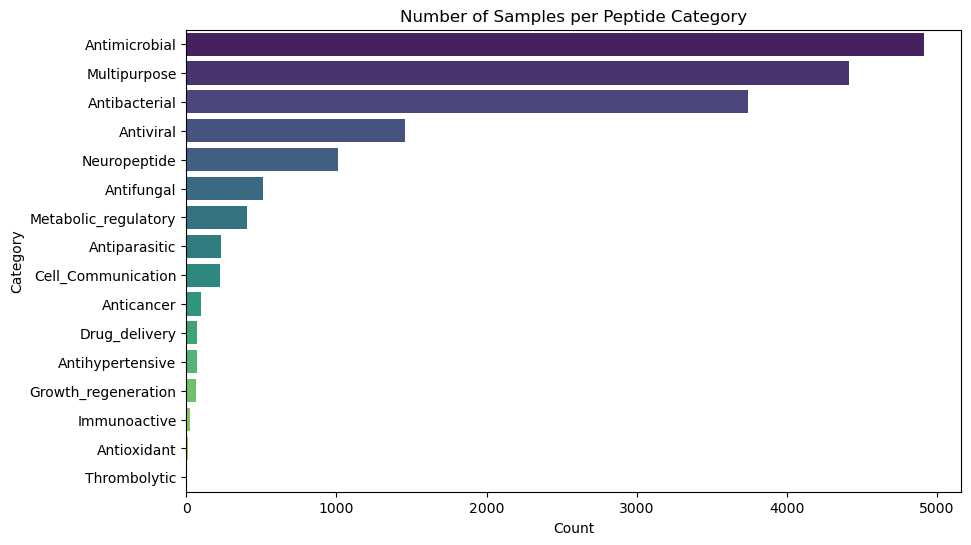

In [33]:
# 1. Get the exact counts
category_counts = labels['MAIN_Category'].value_counts()
print(category_counts)

# 2. Visualize the distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
plt.title('Number of Samples per Peptide Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# It is best practice to scale data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings_finetuned)

# Keep 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"Reduced dimensions: {X_pca.shape[1]}")

Original dimensions: 200
Reduced dimensions: 14


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
# Encode string labels into numbers
le = LabelEncoder()
y_main = le.fit_transform(labels['MAIN_Category'])

# Split the data (stratify ensures proportional class representation in the test set)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_main, test_size=0.2, random_state=42, stratify=y_main
)

# Initialize model with 'balanced' class weights to handle your imbalanced data
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Initialize logistic regression
lr_model = LogisticRegression(
    solver='lbfgs',            # Supports multinomial
    class_weight='balanced',   # Handle imbalance
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

                      precision    recall  f1-score   support

       Antibacterial       0.68      0.74      0.71       748
          Anticancer       0.67      0.10      0.17        20
          Antifungal       0.87      0.70      0.77       102
    Antihypertensive       0.00      0.00      0.00        15
       Antimicrobial       0.83      0.88      0.85       983
         Antioxidant       0.00      0.00      0.00         3
       Antiparasitic       0.87      0.59      0.70        46
           Antiviral       0.91      0.83      0.87       292
  Cell_Communication       0.80      0.36      0.49        45
       Drug_delivery       1.00      0.20      0.33        15
 Growth_regeneration       0.50      0.08      0.13        13
        Immunoactive       0.75      0.60      0.67         5
Metabolic_regulatory       0.86      0.63      0.73        81
        Multipurpose       0.64      0.63      0.63       882
        Neuropeptide       0.64      0.86      0.73       202
       

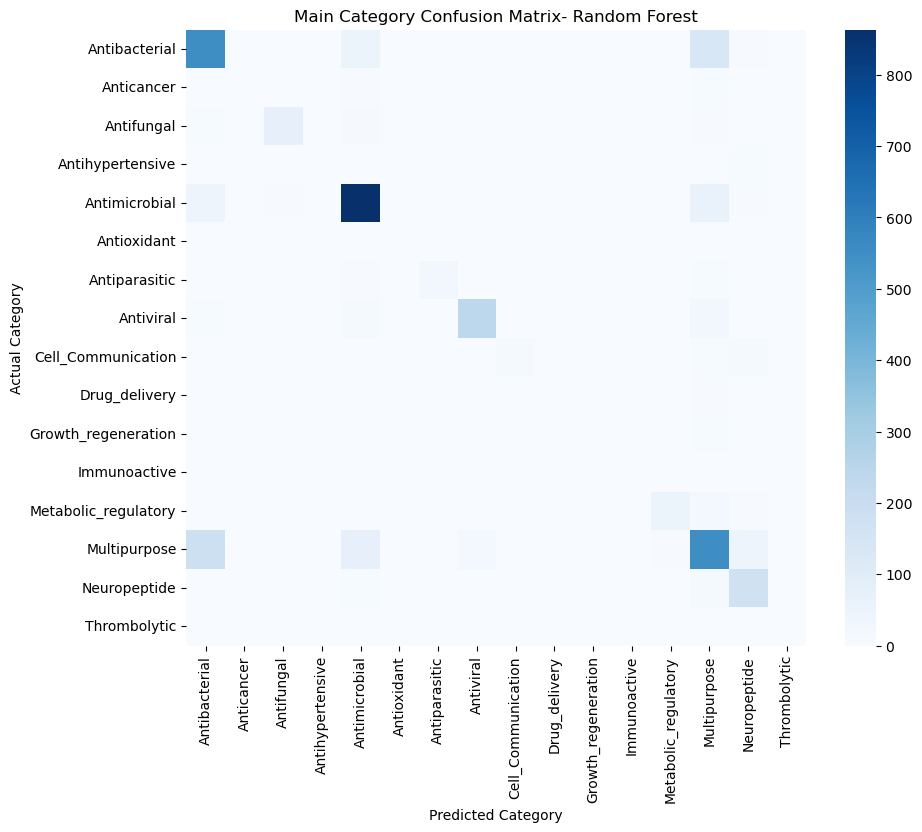

In [37]:
#Random forest plotting

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf_model.predict(X_test)

# 1. Print detailed text metrics
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# 2. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.title('Main Category Confusion Matrix - Random Forest')
plt.show()

                      precision    recall  f1-score   support

       Antibacterial       0.66      0.67      0.66       748
          Anticancer       0.04      0.40      0.08        20
          Antifungal       0.47      0.82      0.60       102
    Antihypertensive       0.08      0.53      0.14        15
       Antimicrobial       0.89      0.74      0.81       983
         Antioxidant       0.00      0.00      0.00         3
       Antiparasitic       0.22      0.78      0.35        46
           Antiviral       0.84      0.82      0.83       292
  Cell_Communication       0.28      0.51      0.37        45
       Drug_delivery       0.18      0.73      0.29        15
 Growth_regeneration       0.18      0.77      0.29        13
        Immunoactive       0.08      1.00      0.15         5
Metabolic_regulatory       0.64      0.80      0.71        81
        Multipurpose       0.57      0.24      0.34       882
        Neuropeptide       0.79      0.49      0.61       202
       

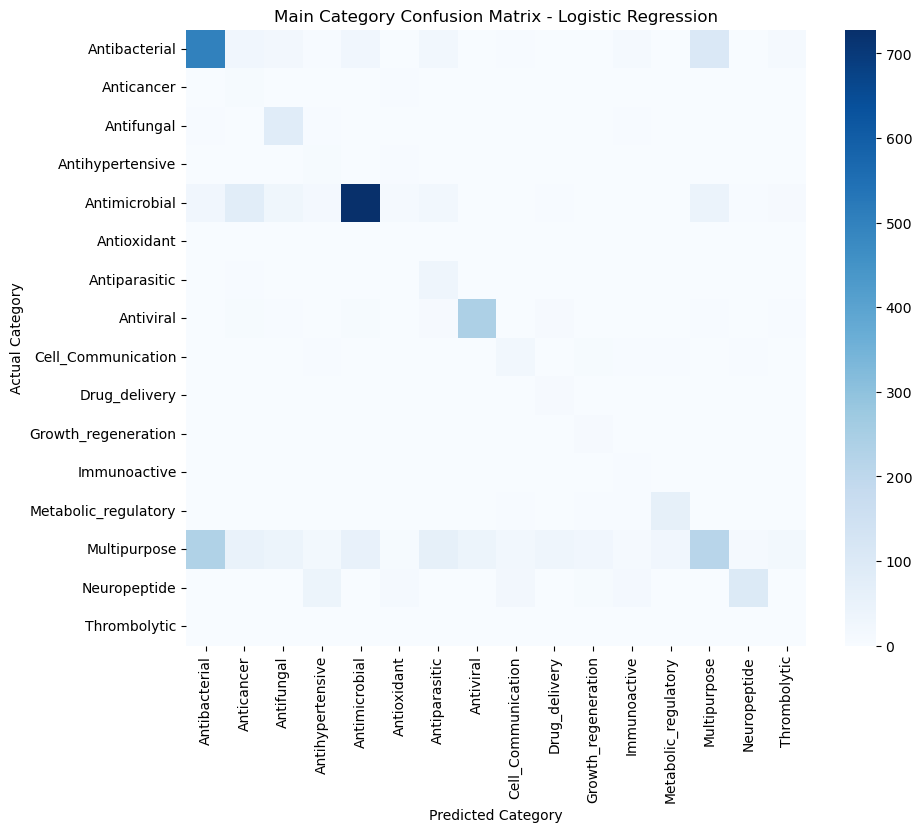

In [38]:
#logistic regression plotting 

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using Logistic Regression model
y_pred = lr_model.predict(X_test)

# 1. Print detailed text metrics
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    zero_division=0
))

# 2. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=False,
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.title('Main Category Confusion Matrix - Logistic Regression')
plt.show()